In [1]:
from mazelib.solve.ShortestPath import ShortestPath
from torchsummary import summary
from mazelib.generate.Prims import Prims
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mazelib import Maze
import torch.nn as nn
import numpy as np
import torch

In [208]:
class ConvAutoEncoder(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=8, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    
model = ConvAutoEncoder()
input_data = torch.randn(1, 1, 15, 15)
output_data = model(input_data)
print("Output shape:", output_data.shape)

Output shape: torch.Size([1, 1, 15, 15])


In [211]:
def show_PNG(grid):
    """Generate a simple image of the maze."""
    plt.figure(figsize=(10, 5))
    plt.imshow(grid, cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()


def generate_data(maze_size: int, data_size: int) -> list:
    """Generate a list of mazes and their solutions."""
    data = []
    for _ in range(data_size):
        maze = Maze()
        maze.generator = Prims(maze_size, maze_size)
        maze.generate()
        maze.solver = ShortestPath()
        maze.generate_entrances()
        maze.solve()
        solution = maze.solutions[0]
        maze_solve = np.ones((maze_size * 2 + 1, maze_size * 2 + 1))
        for x, y in solution:
            maze_solve[x, y] = 0
        maze.grid[maze.start] = 0
        maze.grid[maze.end] = 0

        data.append((maze.grid, maze_solve))

    return data


mazes = generate_data(7, 1000)

model = ConvAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for maze, solution in mazes:
        maze = torch.tensor(maze).unsqueeze(0).unsqueeze(0).float()
        solution = torch.tensor(solution).unsqueeze(0).unsqueeze(0).float()

        output = model(maze)

        # reshape the output to match the target


        loss = criterion(output, solution)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/10], Loss: {loss.item():.4f}')

    print('---')

Epoch [1/10], Loss: 0.6390
Epoch [1/10], Loss: 0.6395
Epoch [1/10], Loss: 0.6400
Epoch [1/10], Loss: 0.6323
Epoch [1/10], Loss: 0.6362
Epoch [1/10], Loss: 0.6266
Epoch [1/10], Loss: 0.6195
Epoch [1/10], Loss: 0.6039
Epoch [1/10], Loss: 0.5954
Epoch [1/10], Loss: 0.5934
Epoch [1/10], Loss: 0.5833
Epoch [1/10], Loss: 0.5407
Epoch [1/10], Loss: 0.5250
Epoch [1/10], Loss: 0.5096
Epoch [1/10], Loss: 0.5150
Epoch [1/10], Loss: 0.4860
Epoch [1/10], Loss: 0.5105
Epoch [1/10], Loss: 0.4523
Epoch [1/10], Loss: 0.3762
Epoch [1/10], Loss: 0.3958
Epoch [1/10], Loss: 0.3799
Epoch [1/10], Loss: 0.2956
Epoch [1/10], Loss: 0.5031
Epoch [1/10], Loss: 0.3438
Epoch [1/10], Loss: 0.3984
Epoch [1/10], Loss: 0.3044
Epoch [1/10], Loss: 0.4063
Epoch [1/10], Loss: 0.3438
Epoch [1/10], Loss: 0.4879
Epoch [1/10], Loss: 0.4326
Epoch [1/10], Loss: 0.3463
Epoch [1/10], Loss: 0.3451
Epoch [1/10], Loss: 0.4012
Epoch [1/10], Loss: 0.3645
Epoch [1/10], Loss: 0.3832
Epoch [1/10], Loss: 0.3395
Epoch [1/10], Loss: 0.3138
E

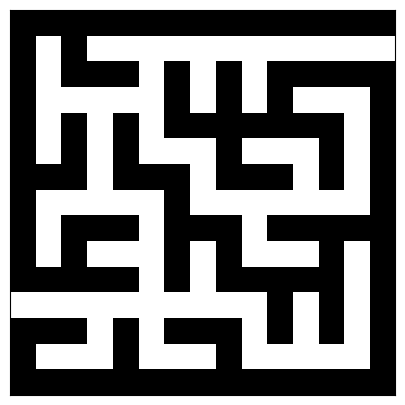

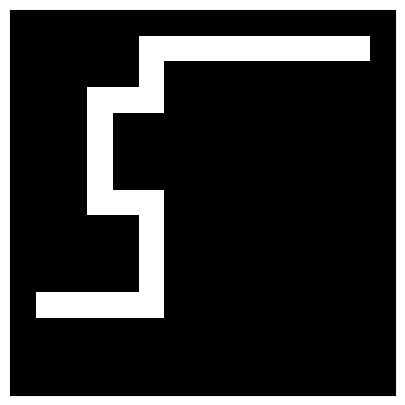

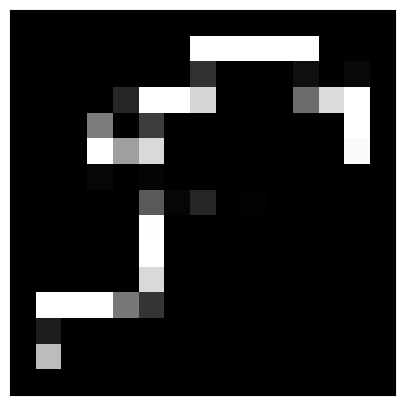

In [218]:
import random
mazes = generate_data(7, 1)
maze, solution = random.choice(mazes)

output = model(torch.tensor(maze).unsqueeze(0).unsqueeze(0).float())

show_PNG(maze)
show_PNG(solution)
show_PNG(output.detach().numpy().squeeze())